In [1]:
import skeliner as sk

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [2]:
MESH_PATH = "../data/720575940545220339.obj"
mesh = sk.io.load_mesh(MESH_PATH)

In [3]:
skel = sk.skeletonize(mesh, 
    detect_soma="pre", # default is "pre": the pre-skeletonization auto soma detection
                       # if a seed point is provided, it will be become (guided) semi-auto 
                       # "seed": fix soma location with a seed point
                       # "post" is the post-skeletonization soma detection (averaged nodes with large radius as soma)
    # soma_seed_point= (..., ..., ...) # if soma location is known, it will become semi-auto
    # soma_seed_radius = ... # if a radius is provided, it will overwrite the estimated, good for pruning overshoots
    # --- auto soma detection parameters ---
    # --- the procedure is overestimate -> cut -> dilate
    soma_seed_radius_multipler=10.0, # the auto probing radius is this times the average distance between vertices
    soma_density_cutoff=0.75, # higher this value, the smaller the soma (mostly)
    soma_dilation_steps=1, # higher this value, the larger the soma
    # --- post-processing parameters ---
    collapse_soma=True, # default
    bridge_components=True, # default
    prune_tiny_neurites=True, # default
    verbose=True,
)

[skeliner] starting skeletonisation
 ↳  build surface graph                          … 3.5 s
 ↳  detect soma                                  … 2.3 s
 ↳  partition surface into geodesic shells       … 3.3 s
 ↳  place centroids + local radius               … 3.4 s
 ↳  map mesh edges → skeleton edges              … 0.5 s
 ↳  merge redundant near-soma nodes              … 0.0 s
 ↳  reconnect mesh gaps                          … 1.5 s
 ↳  build global minimum-spanning tree           … 0.1 s
 ↳  prune tiny soma-attached branches            … 0.0 s
TOTAL (soma + core + post)                       … 14.7 s (5.8 + 7.3 + 1.5)


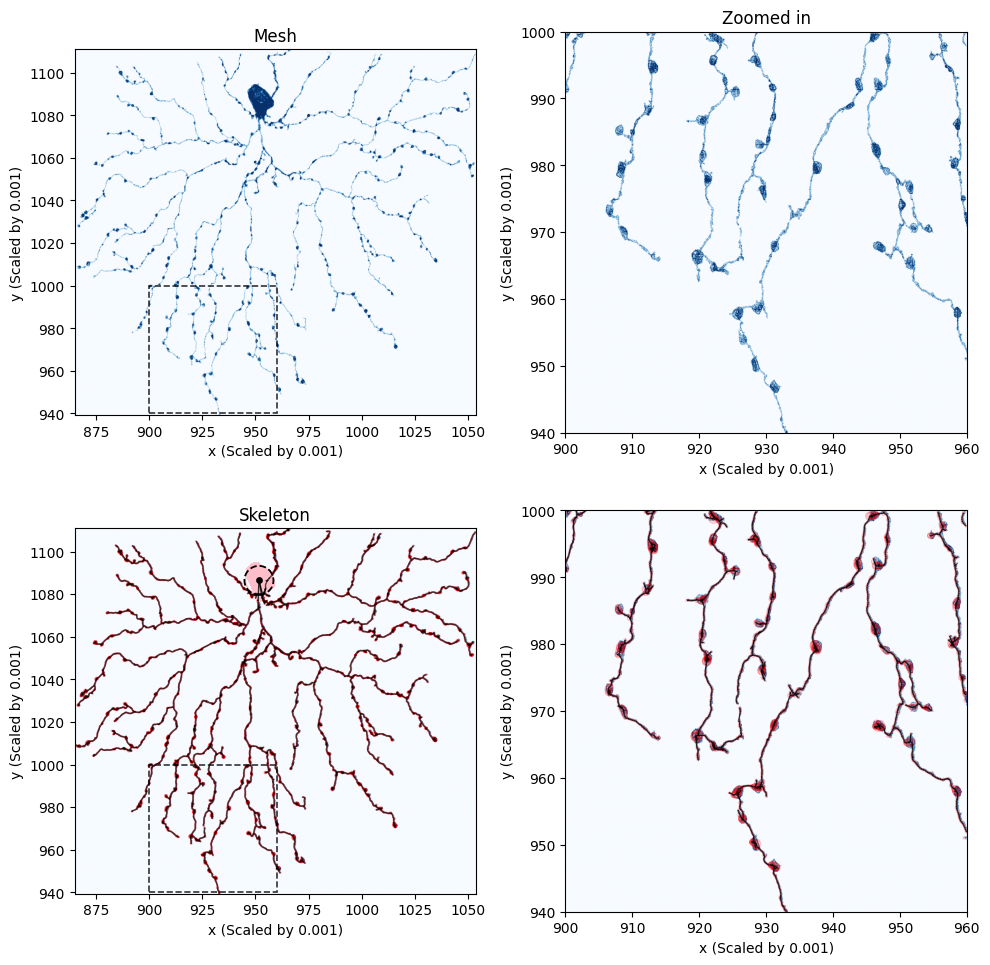

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3, # nm → µm 
    draw_skel=False,
    draw_edges=False,
    draw_soma_mask=False,
    ax=ax[0, 0]
)
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3, # nm → µm 
    draw_edges=True,
    draw_soma_mask=True,
    ax=ax[1, 0]
)

x0, x1 = (900, 960)
y0, y1 = (940, 1000)
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3,  
    xlim=(x0, x1),
    ylim=(y0, y1),
    draw_skel=False,
    draw_edges=False,
    ax=ax[0, 1],
)
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3,  
    xlim=(x0, x1),
    ylim=(y0, y1),
    draw_edges=True,
    ax=ax[1, 1],
)
ax[0, 0].set_title("Mesh")
ax[1, 0].set_title("Skeleton")
ax[0, 1].set_title("Zoomed in")

rect = [Rectangle(
    (x0, y0),          # lower-left corner
    x1-x0, y1-y0,
    linewidth=1.2,
    edgecolor="black",
    linestyle="--",
    facecolor="none",
    alpha=0.8,
    zorder=3,          # above background & edges, below nodes
) for _ in range(2)]
ax[0, 0].add_patch(rect[0])
ax[1, 0].add_patch(rect[1])

for a in ax.flatten():
    a.set_aspect("equal")
    
fig.tight_layout()

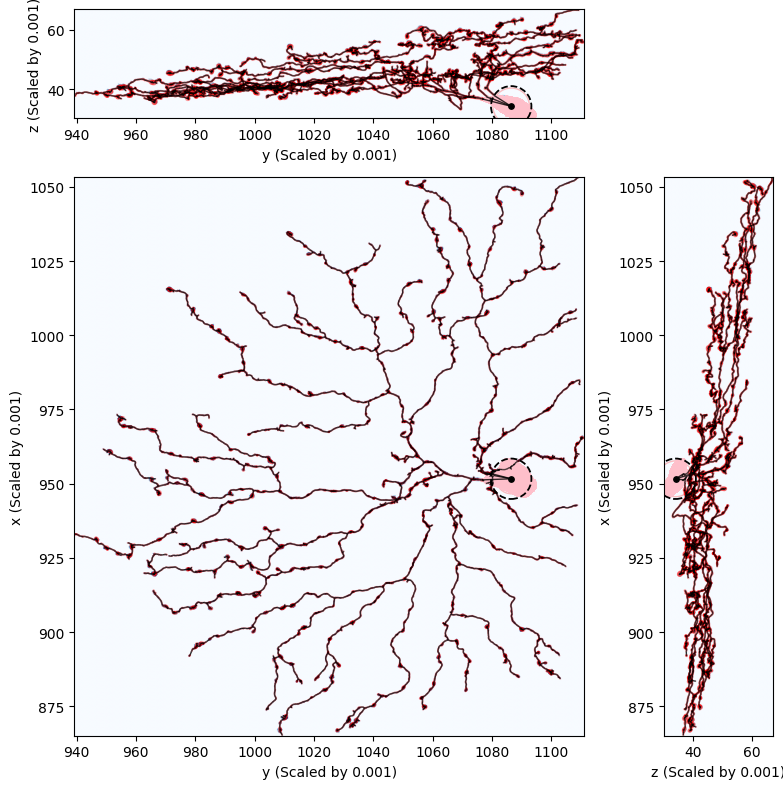

In [5]:
import numpy as np
# --- 0. one global bounding-box ----------------------------------------
v = mesh.vertices * 1e-3                      # nm → µm once
gx = (v[:, 0].min(), v[:, 0].max())   # x (for XZ)
gy = (v[:, 1].min(), v[:, 1].max())   # y (for XY, YZ)
gz = (v[:, 2].min(), v[:, 2].max())   # z (for YZ, XZ)

dx = np.ptp(v[:, 0])          # Δx
dy = np.ptp(v[:, 1])          # Δy
dz = np.ptp(v[:, 2])          # Δz


# --- 1. build the 2×2 mosaic ------------------------------------------
mosaic = """
B.
AC
"""

fig, ax = plt.subplot_mosaic(
    mosaic,
    gridspec_kw={
        "height_ratios": [dz, dx],   
        "width_ratios":  [dy, dz],   
    },
    figsize=(8, 8),
)

# make every panel square in data-pixel space
sk.plot2d(skel, mesh, plane="yx", scale=1e-3,
          ax=ax["A"], xlim=gy, ylim=gx,
          draw_edges=True, draw_soma_mask=True)
ax["A"].set_aspect("equal")        

sk.plot2d(skel, mesh, plane="yz", scale=1e-3,
          ax=ax["B"], xlim=gy, ylim=gz,
          draw_edges=True, draw_soma_mask=True)
ax["B"].set_aspect("equal")          

sk.plot2d(skel, mesh, plane="zx", scale=1e-3,
          ax=ax["C"], xlim=gz, ylim=gx,
          draw_edges=True, draw_soma_mask=True)
ax["C"].set_aspect("equal")          


In [6]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-05-20 22:54:34CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

numpy     : 2.0.2
matplotlib: 3.10.3
skeliner  : 0.1.0

Watermark: 2.5.0

